### Задача
1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
   * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
   * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
   * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
   * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
3. Продемонстрировать использование разных тестов для проверки статистической значимости сделанных выводов:
   * тесты для количественного признака:
   * для одной выборки;
   * для двух выборок;
   * для нескольких выборок;
   * тест для категориальных признаков.

In [1]:
# Загрузка необходимых библиотек
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels import stats as sms
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('asset-v1.zip')
df = data.copy()
df.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


* work_year - Год, в котором была выплачена зарплата.
* experience_level - Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
* employment_type - Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
* job_title - Роль, в которой соискатель работал в течение года.
* salary - Общая выплаченная валовая сумма заработной платы.
* salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* remote_ratio - Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
* company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size - Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

#### Описательный анализ данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В данных 607 записей, без пропущенных значений.


#### Проверка данных на наличие полных дубликатов.

In [4]:
print('Количество полных будликатов: {}'.format(df[df.duplicated].shape[0]))

Количество полных будликатов: 0


В столбце Unnamed: 0 не содержится полезной информации, т.к. она отражает нумерацию индексов, поэтому его можно удалить.

In [5]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

#### Построение графиков распределения зарплаты в долларах США.

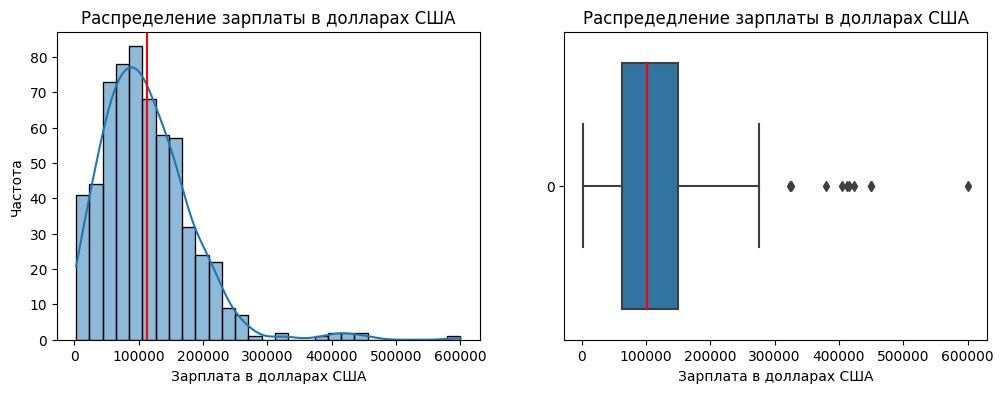

In [6]:
fig, axes = plt.subplots(1,2, figsize =(12, 4))

sns.histplot(df['salary_in_usd'], kde = True, ax = axes[0])
axes[0].set_title("Распределение зарплаты в долларах США")
axes[0].set(xlabel = "Зарплата в долларах США", ylabel = "Частота")
axes[0].axvline(df['salary_in_usd'].mean(), color = 'red', linestyle = '-' )



sns.boxplot(data['salary_in_usd'], ax = axes[1], orient = 'h', medianprops = {'color':'red', 'linestyle': '-'})
axes[1].set(xlabel = 'Зарплата в долларах США')
axes[1].set_title('Распредедление зарплаты в долларах США')

plt.show()

--------------
#### Выводы по графикам:
* среднее значение находиться в районе 110к - 115к;
* большая часть значений сосредоточена от 10к - 200к;

* распределение не является нормальным;
* имеется небольшое кол-во выбросов.
--------------

In [7]:
# С учётом выбросов использовал для поиска центральной тенденции медианное значение.
df_salary = df.groupby('job_title')['salary_in_usd'].median().round(0)
print('\033[1m' + 'Топ 10 самых высоких средних зарплат' +'\033[0m')
print(df_salary.sort_values(ascending=False)[0:10])
print('\033[1m' + '\nТоп 10 самых кизких срежних зарплат' + '\033[0m')
print(df_salary.sort_values()[0:10])

Топ 10 самых высоких средних зарплат
job_title
Data Analytics Lead         405000.0
Financial Data Analyst      275000.0
Head of Data                200000.0
Principal Data Engineer     200000.0
Data Architect              180000.0
Analytics Engineer          179850.0
Principal Data Scientist    173762.0
Director of Data Science    168000.0
Data Specialist             165000.0
Applied Data Scientist      157000.0
Name: salary_in_usd, dtype: float64

Топ 10 самых кизких срежних зарплат
job_title
3D Computer Vision Researcher                5409.0
Product Data Analyst                        13036.0
Computer Vision Engineer                    26304.0
NLP Engineer                                37236.0
Big Data Engineer                           41306.0
AI Scientist                                45896.0
ETL Developer                               54957.0
Applied Machine Learning Scientist          56700.0
Machine Learning Infrastructure Engineer    58255.0
Data Science Engineer           

#### Распределение зарплат с учётом опыта раблоты.


Распределение центральной тенеденции в зависимости от опыта работы
experience_level
EX    171437.5
SE    135500.0
MI     76940.0
EN     56500.0
Name: salary_in_usd, dtype: float64


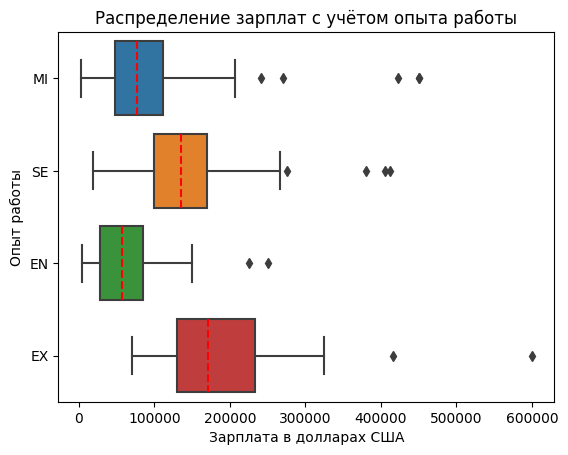

In [36]:
df_experience = df.groupby('experience_level')['salary_in_usd'].median()
print('\033[1m' + 'Распределение центральной тенеденции в зависимости от опыта работы'+ '\033[0m')
print(df_experience.sort_values(ascending=False))
ax = sns.boxplot(df, x='salary_in_usd', y = 'experience_level', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel = 'Зарплата в долларах США', ylabel = 'Опыт работы')
plt.title('Распределение зарплат с учётом опыта работы')
plt.show()

----------------
#### Выводы по графику.
* Зарплаты в категории EX — Executive-level/Director самые высокие.
* Самые низкие в категории EN — Entry-level/Junior.
* В каждой группе имеется несколько выбросов.
----------------

### Распределение зарплат с учётом занятости.

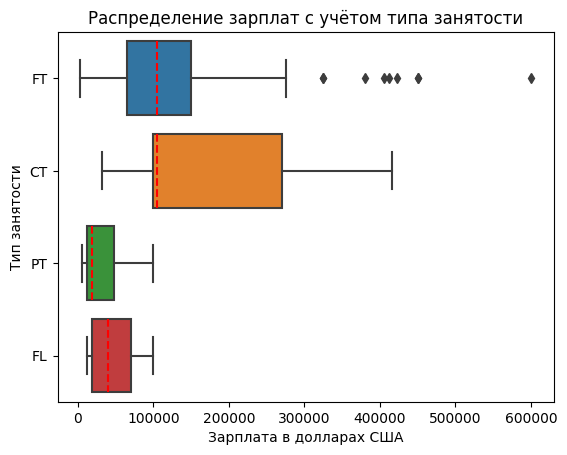

In [9]:
ax = sns.boxplot(df, x='salary_in_usd', y = 'employment_type', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel = 'Зарплата в долларах США', ylabel = 'Тип занятости')
plt.title('Распределение зарплат с учётом типа занятости')
plt.show()

In [10]:
df_group_type_exp = df.groupby('employment_type')['salary_in_usd'].median().round(0)
print(('\033[1m' + 'Распределение центральной тенеденции в зависимости от типа занятости'+ '\033[0m'))
print(df_group_type_exp.sort_values(ascending=False))

Распределение центральной тенеденции в зависимости от типа занятости
employment_type
CT    105000.0
FT    104196.0
FL     40000.0
PT     18818.0
Name: salary_in_usd, dtype: float64


------------
#### Выводы по графику.
* Самые высокие зарплаты у сотрудников, которы работают по "контракту - CT".
* Самые низкие на "фрилансе - FL" и "неполный рабочий день - PT".
* Посередине расположен тип занятости - "полный рабочий день - FT". Едиснтвенная категория в которой наблюдаются выбросы.
* Медианные значения типа "контракт - СТ" и "полный рабочий день - FT" почти равны.
------------

### Распределение зарплат с 2020 года по 2022 у Data Scientist.

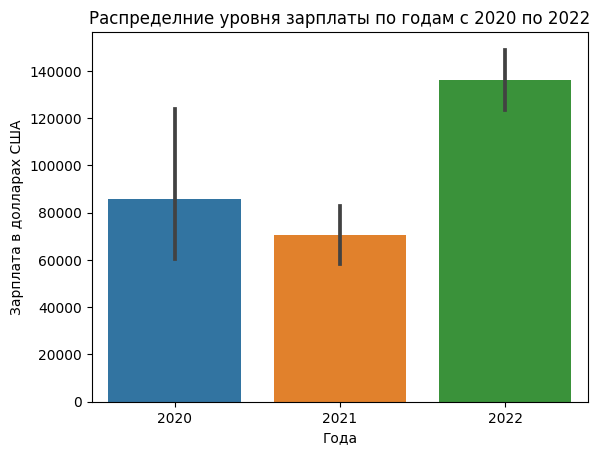

In [11]:
ds_df = df[df['job_title'] == 'Data Scientist']
ax = sns.barplot(df, x = ds_df['work_year'], y = ds_df['salary_in_usd'])
ax.set(xlabel = 'Года', ylabel = 'Зарплата в долларах США')
plt.title('Распределние уровня зарплаты по годам с 2020 по 2022')
plt.show()

---------------
#### Выводы по графику.
* Наблюдается спад уровня зарплат в 2021 году. Разница между 2020 и 2021, приверно 18-20к.
* В 2022 году виден резкий рост зарплаты, примерно в два раза.
* Нельзя чётко заключить ростут зарплаты или нет, т.к. трёх лет недостаточно.
---------------

### Распределение зарплат по странам.


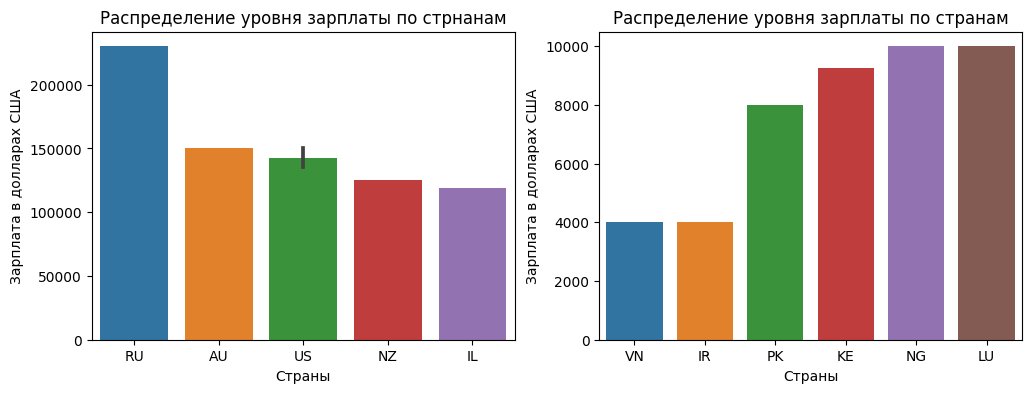

In [12]:
df_country = df.groupby(['company_location', 'company_size'])['salary_in_usd'].median().reset_index(name='salary')
df_country.sort_values(by = 'salary', ascending= False)

df_country_top_five = df_country.sort_values(by = 'salary', ascending= False)[0:6]
df_country_low_five = df_country.sort_values(by = 'salary')[0:6]
fig, axes = plt.subplots(1,2, figsize =(12, 4))

sns.barplot(df_country_top_five, x ='company_location', y = 'salary', ax = axes[0])
axes[0].set_title("Распределение уровня зарплаты по стрнанам")
axes[0].set(ylabel = "Зарплата в долларах США", xlabel = "Страны")


sns.barplot(df_country_low_five, x ='company_location', y = 'salary', ax = axes[1])
axes[1].set(ylabel = "Зарплата в долларах США", xlabel = "Страны")
axes[1].set_title('Распределение уровня зарплаты по странам')

plt.show()


In [13]:
print('Количество записей с локацией компании в России (RU): {}'.format(df[df['company_location'] == 'RU'].count()[0]))
print('\033[1m'+'Количество записей по странам'+'\033[0m')
print(df['company_location'].value_counts().head(10))

Количество записей с локацией компании в России (RU): 2
Количество записей по странам
company_location
US    355
GB     47
CA     30
DE     28
IN     24
FR     15
ES     14
GR     11
JP      6
NL      4
Name: count, dtype: int64


------------
#### Выводы по графикам.
* Т.к. в данных нет достаточного количества записей по зарплатам в каждой стране, верные выводы сделать не получится.
--------------

###  Соотношения зарплаты в 2022 году у Data Scientist и Data Engineer.

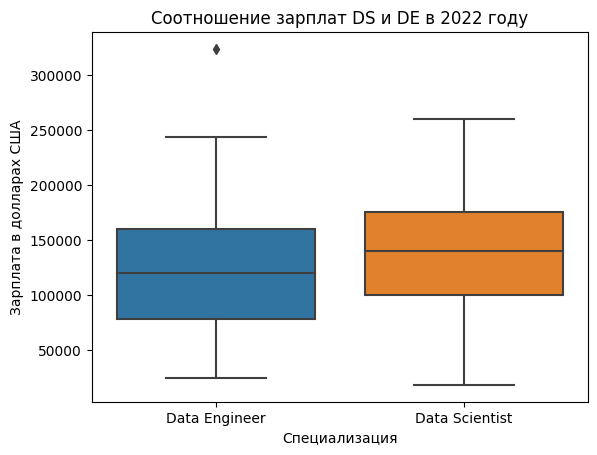

In [14]:
df_ds_de = df[((df['job_title'] == 'Data Scientist') | (df['job_title'] == 'Data Engineer')) & (df['work_year'] == 2022)]

ax = sns.boxplot(df_ds_de, x = df_ds_de['job_title'], y = df_ds_de['salary_in_usd'] )
ax.set_title('Соотношение зарплат DS и DE в 2022 году')
ax.set(ylabel = 'Зарплата в долларах США', xlabel = 'Специализация')
plt.show()

-------------
#### Выводы по графику
* Зарплата DS выше, чем у DE, примерно на 15-20к долларов.
* Есть один выброс в категории DE.
---------------

### Соотношении зарплат Data Scientist в компаниях разного размера.

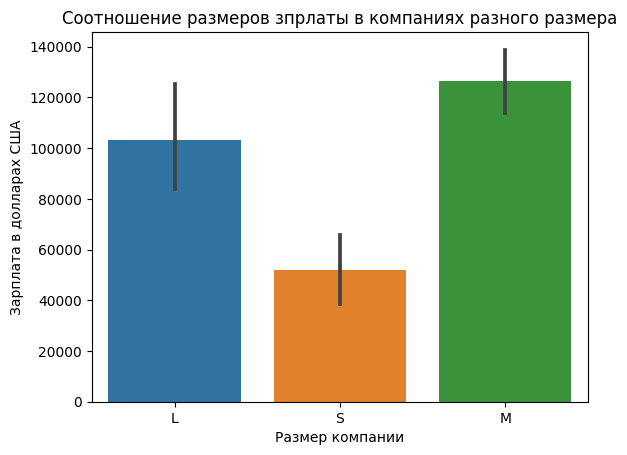

In [15]:
ax = sns.barplot(df[df['job_title'] == 'Data Scientist'], x = 'company_size', y = 'salary_in_usd')
ax.set_title('Соотношение размеров зпрлаты в компаниях разного размера')
ax.set(xlabel = 'Размер компании', ylabel='Зарплата в долларах США')
plt.show()

-----------
#### Выводы по графику
* Зарплаты отличаются в компаниях разного размера друг от друга.
* Меньше всего уровень зарплаты в компаниях до 50-ти человек - "S". Примерно на уровне 50-52к долларов.
* Самый выскоий уровень зарплаты в компании размером от 50-ти до 250-ти человек - "M". Примерно на уровне 120-125к долларов.
* Средний уровень зарплаты у крупных компаний от 250-ти сотрудников - "L". Примерно на уровне 100-105к долларов.
------------

#### Соотношение кол-ва удалённый работы и зарплаты в долларах США для Data Scientist.


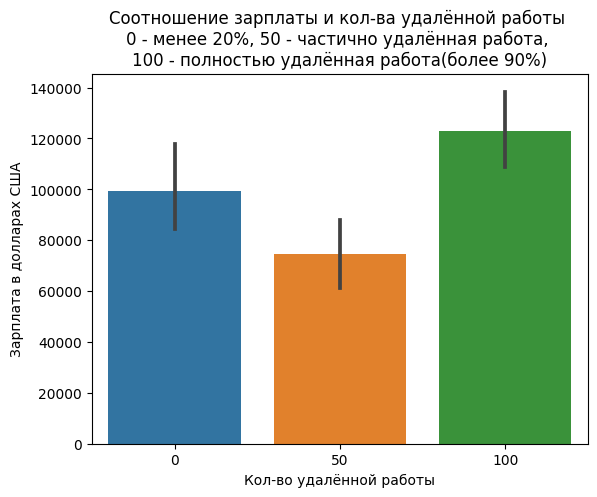

In [16]:
ax = sns.barplot(df[df['job_title'] == 'Data Scientist'], x = 'remote_ratio', y = 'salary_in_usd')
ax.set_title('Соотношение зарплаты и кол-ва удалённой работы \n0 - менее 20%, 50 - частично удалённая работа, \n100 - полностью удалённая работа(более 90%)')
ax.set(xlabel = 'Кол-во удалённой работы', ylabel = 'Зарплата в долларах США')
plt.show()

---------------
#### Выводы по графику.
* Больше всех получают те, кто работает полностью на удалённой работе (боле 90%).
* Следом идут те, кто у основном работают в офисе.
* Меньше всех получают люди с совмещённом типом работы, частично удалённая, частично в офисе.
* Учитывая, что разница между меньшим и большим показателем в 40к долларов, то можно заключить, что она значительная.
-------------

#### Соотношение позиций Data Scientist и Data Engineer в компаниях разного размера.

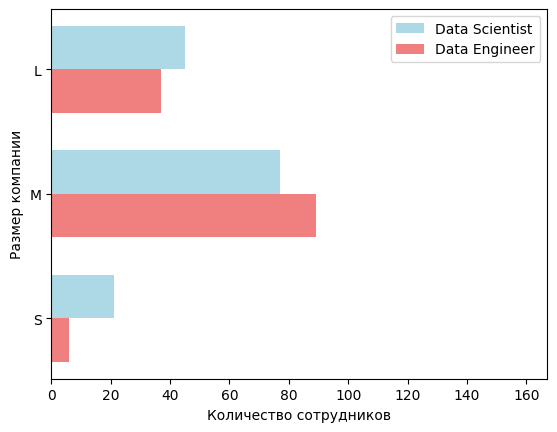

In [17]:
df_group_ds_de = df[(df['job_title'] == 'Data Scientist') | (df['job_title'] == 'Data Engineer')]
grouped = df_group_ds_de.groupby(['company_size', 'job_title']).size().unstack().reset_index()

width = 0.35

indices = np.arange(len(grouped['company_size']))

fig, ax = plt.subplots()
ax1 = ax.barh(indices, grouped['Data Scientist'], width, color='lightblue', label='Data Scientist')
ax2 = ax.barh(indices + width, grouped['Data Engineer'], width, color='lightcoral', label='Data Engineer')

ax.set_xlabel('Количество сотрудников')
ax.set_ylabel('Размер компании')
ax.set_yticks(indices + width / 2)
ax.set_yticklabels(grouped['company_size'])

ax.legend()

plt.gca().invert_yaxis()
plt.xlim(0, max(grouped['Data Scientist']) + max(grouped['Data Engineer']) + 1)

plt.show()


---------------
#### Выводы по графику:
* Кол-во DS превышает кол-во DE в очень крупых компаниях (L) и маленьких компаниях (S).
* В компаниях среднего размера (М) кол-во DE превышает кол-во DS. 
* В целом, разрыв между кол-вом сотрудников не очень большой.
-----------------

#### Соотношение удалённой работы в компаниях разного размера.


c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


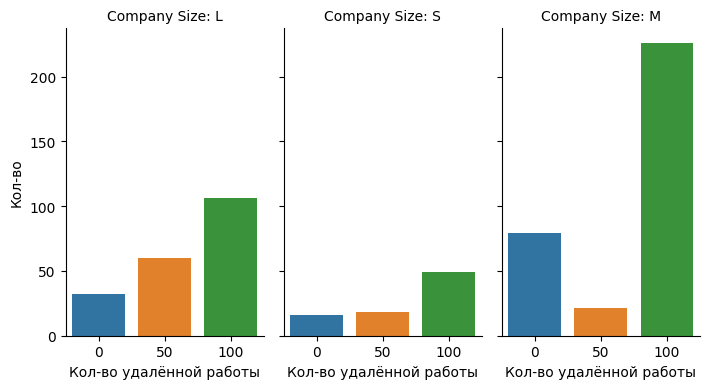

In [31]:
ax = sns.catplot(
    data=df, x="remote_ratio", col="company_size",
    kind="count", height=4, aspect=.6,
)

ax.set_axis_labels("Remote Ratio", "Count")
ax.set_titles("Company Size: {col_name}")
ax.set_xlabels("Кол-во удалённой работы")
ax.set_ylabels("Кол-во")
plt.show()


-------------------
#### Выводы по графикам:
* В компаниях любого размера, показатель "100" (более 90% удалённой работы), превышает все остальные показатели.
* В компаниях срденего размера (М) самый выскоий показтель по удалённой работе.
* Так же стоит отметить, что в компании среднего размера (M), показатель "0" (остутсвие удалённой работы), превышает частично удалённую занятость, в отличие от компаний размера "L" и "S".
------------------

#### Перекодирование некоторых признаков.

In [37]:
# One-Hot Encoding для признака "company_size"

import category_encoders as ce

df_one_hot = pd.get_dummies(df, columns=['company_size'], dtype = 'int')


In [38]:
# One-Hot Encoding для признака "remote_ratio"

df_one_hot_2 = pd.get_dummies(df_one_hot, columns=['remote_ratio'], dtype = 'int')


In [39]:
# One-Hot Encoding для признака "employment_type"

df_one_hot_3 = pd.get_dummies(df_one_hot_2, columns=['employment_type'], dtype='int')


In [40]:
# One-Hot Encoding для признака "experience_level"

df_one_hot_4 = pd.get_dummies(df_one_hot_3, columns= ['experience_level'], dtype = 'int')


In [41]:
# One-Hot Encoding для признака "work_year"

df_one_hot_5 = pd.get_dummies(df_one_hot_3, columns= ['work_year'], dtype = 'int')

#### Построение тепловой карты корреляции признаков.

<Axes: >

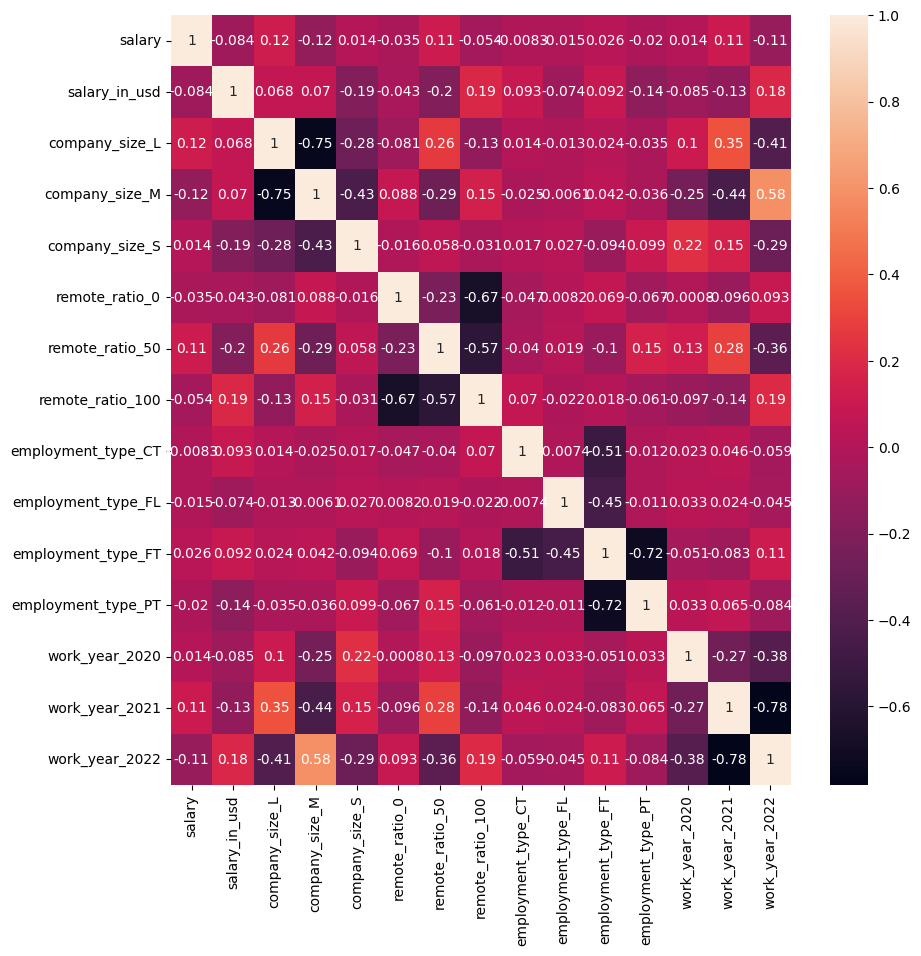

In [42]:
ax, fig = plt.subplots(figsize = (10,10))
sns.heatmap(df_one_hot_5.corr(numeric_only = True), annot = True)

------------------
#### Выводы по графику.
* Сильная отрицательная корреляция наблюдается в признаках:
    * "company_size_M" и "company_size_L" (рамер компании М - средняя, L - болашя) 
    * "remote_ratio_100", "remote_ratio_0", "remote_ratio_50" (кол-во удалённой работы)
    * "experience_level_MI" и "experience_level_SE" (MI — Mid-level/Intermediate, SE — Senior-level/Expert)
    * "work_year_2021" и "work_year_2022"
-----------------

## Статистический анализ данных

In [43]:
alpha = 0.05
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### Наблюдается ли ежегодный рост зарплат у Data Scientist?

*Нулевая гипотеза* ($H_0$): Ежегодный рост зарплаты ($μ_1$) у специалистов Data Scientist отсутствует  ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Ежегодный рост зарплаты ($μ_1$) у специалистов Data Scientist наблюдается ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [44]:
df_ds_2020 = df.loc[(df['job_title'] == 'Data Scientist') & (df['work_year'] == 2020)]
df_ds_2021 = df.loc[(df['job_title'] == 'Data Scientist') & (df['work_year'] == 2021)]
df_ds_2022 = df.loc[(df['job_title'] == 'Data Scientist') & (df['work_year'] == 2022)]

print('Для 2020 года: ')
result = stats.shapiro(df_ds_2020['salary_in_usd'])
decision_normality(result[1])

print('Для 2021 года: ')
result = stats.shapiro(df_ds_2021['salary_in_usd'])
decision_normality(result[1])

print('Для 2022 года: ')
result = stats.shapiro(df_ds_2022['salary_in_usd'])
decision_normality(result[1])                       

Для 2020 года: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021 года: 
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022 года: 
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


* Так как групп больше трёх, группы независимы, распределение частично нормальное, то подойдёт критерий Краскера-Уоллиса.

In [45]:
_,p= stats.kruskal(df_ds_2020['salary_in_usd'], df_ds_2021['salary_in_usd'], df_ds_2022['salary_in_usd'])
print(decision_hypothesis(p))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
None


* Вывод: Есть основания утверждать, что зарплаты Data Scientist растут с каждым годом.

In [46]:
df_ds_2020_1 = df_one_hot_5.loc[df_one_hot_5['job_title'] == 'Data Scientist','work_year_2020']
df_ds_2021_2= df_one_hot_5.loc[df_one_hot_5['job_title'] == 'Data Scientist','work_year_2021']
df_ds_2022_3= df_one_hot_5.loc[df_one_hot_5['job_title'] == 'Data Scientist','work_year_2022']

print('Для 2020 года: ')
result = stats.shapiro(df_ds_2020_1)
decision_normality(result[1])

print('Для 2021 года: ')
result = stats.shapiro(df_ds_2021_2)
decision_normality(result[1])

print('Для 2022 года: ')
result = stats.shapiro(df_ds_2022_3)
decision_normality(result[1])   
print('\n')
_,p= stats.kruskal(df_ds_2020_1, df_ds_2021_2, df_ds_2022_3)
print(decision_hypothesis(p))

Для 2020 года: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021 года: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2022 года: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
None


#### В компаниях разного размера зарплаты отличаются?

*Нулевая гипотеза* ($H_0$): Зарплаты сотруников компаний разного размера ($μ_1$ - $μ_3$) у специалистов Data SCientist равны.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): Зарплаты сотрудников компаний разного размера ($μ_1$ -$μ_3$) у специалистов Data Scientist отличаются.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данныx является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.


In [47]:
df_ds_size_s = df.loc[(df['company_size'] == 'S') & (df['job_title'] == 'Data Scientist')]
df_ds_size_m = df.loc[(df['company_size'] == 'M') & (df['job_title'] == 'Data Scientist')]
df_ds_size_l = df.loc[(df['company_size'] == 'L') & (df['job_title'] == 'Data Scientist')]

print('Для компаний размером S - менее 50-ти человек: ')
result = stats.shapiro(df_ds_size_s['salary_in_usd'])
decision_normality(result[1])

print('Для компаний размером M - от 50-ти до 250-ти человек: ')
result = stats.shapiro(df_ds_size_m['salary_in_usd'])
decision_normality(result[1])

print('Для компаний размером L - более 250-ти человек: ')
result = stats.shapiro(df_ds_size_l['salary_in_usd'])
decision_normality(result[1])

Для компаний размером S - менее 50-ти человек: 
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для компаний размером M - от 50-ти до 250-ти человек: 
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для компаний размером L - более 250-ти человек: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


* Так как распределение в одном из пунктов не является нормальным, проверяется три признака которые не являются зависимыми, то подойдёт тест Краскера-Уоллиса.

In [48]:
_,p = stats.kruskal(df_ds_size_s['salary_in_usd'], df_ds_size_m['salary_in_usd'], df_ds_size_l['salary_in_usd'])
print(decision_hypothesis(p))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
None


* Вывод: Размер зарплаты в компаниях разного размера отличается.

In [49]:
df_ds_size_s_1 = df_one_hot_5.loc[df_one_hot_5['job_title'] == 'Data Scientist', 'company_size_S']
df_ds_size_m_2 = df_one_hot_5.loc[df_one_hot_5['job_title'] == 'Data Scientist', 'company_size_M']
df_ds_size_l_3 = df_one_hot_5.loc[df_one_hot_5['job_title'] == 'Data Scientist', 'company_size_L']

print('Для компаний размером S - менее 50-ти человек: ')
result = stats.shapiro(df_ds_size_s_1)
decision_normality(result[1])

print('Для компаний размером M - от 50-ти до 250-ти человек: ')
result = stats.shapiro(df_ds_size_m_2)
decision_normality(result[1])

print('Для компаний размером L - более 250-ти человек: ')
result = stats.shapiro(df_ds_size_l_3)
decision_normality(result[1])

_,p = stats.kruskal(df_ds_size_s_1, df_ds_size_m_2, df_ds_size_l_3)
print(decision_hypothesis(p))

Для компаний размером S - менее 50-ти человек: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для компаний размером M - от 50-ти до 250-ти человек: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для компаний размером L - более 250-ти человек: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
None


### Зарплата Data Scientist выше, чем у Data Engineer в 2022 году?

*Нулевая гипотеза* ($H_0$): Зарплата Data Scientist ($μ_1$) меньше или равна зарплате Data Engineer ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Зарплата Data Scientist ($μ_1$) больше зарплаты Data Engineer  ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данныx является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [53]:
df_ds_salary = df.loc[(df['job_title'] == 'Data Scientist') & (df['work_year'] == 2022), 'salary_in_usd']
df_de_salary = df.loc[(df['job_title'] == 'Data Engineer') & (df['work_year'] == 2022), 'salary_in_usd']

print('Для Data Scientist: ')
result = stats.shapiro(df_ds_salary)
print(decision_normality(result[1]))

print('Для Data Engineer: ')
result = stats.shapiro(df_de_salary)
print(decision_normality(result[1]))


Для Data Scientist: 
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
None
Для Data Engineer: 
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
None


* Распределение не является нормальным, групп две и они независимы, то подойдёт U-критерий Манна-Уитни.

In [57]:
_, p= stats.mannwhitneyu(df_ds_salary, df_de_salary, alternative= 'greater')
print(decision_hypothesis(p))

p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
None


* Вывод: Нет оснований утверждать, что зарплата Data Scientist больше зарплаты Data Engineer. 

### Зарплата Data Scienitst в крупных компаниях больше, чем в средних.

*Нулевая гипотеза* ($H_0$): Зарплата Data Scientist в крупной компании ($μ_1$) меньше или равна зарплате Data Scinetist в средней компании ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Зарплата Data Scientist в крупной компании ($μ_1$) больше зарплате Data Scinetist в средней компании ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данныx является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [52]:
df_size_comp_L = df_one_hot_5.loc[df['job_title'] == 'Data Scientist', 'company_size_L']
df_size_comp_M = df_one_hot_5.loc[df['job_title'] == 'Data Scientist', 'company_size_M']

print('Для компании размером более 250-ти человек (L): ')
result = stats.shapiro(df_size_comp_L)
print(decision_normality(result[1]))

print('Для компании размером от 50-ти до 250-ти человек (M): ')
result = stats.shapiro(df_size_comp_M)
print(decision_normality(result[1]))



Для компании размером более 250-ти человек (L): 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
None
Для компании размером от 50-ти до 250-ти человек (M): 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
None


* Т.к. распределения не является нормальным, признаки независимы, подойдёт U-критерий Манна-Уитни

In [99]:
_,p = stats.mannwhitneyu(df_size_comp_L, df_size_comp_M, alternative='greater')
print(decision_hypothesis(p))

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
None


* Вывод: Нет оснований утверждать, что в крупных компаниях (L) платят больше, чем в компаниях среднего размера (М).

### В крупных компаниях специалистов Data Scientist больше, чем специалистов Data Engineer.

*Нулевая гипотеза* ($H_0$): Кол-во специалистов Data Scientist в крупной компании ($μ_1$) меньше или равно кол-ву специалистов Data Engineer в средней компании ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Кол-во специалистов Data Scientist в крупной компании ($μ_1$) больше кол-ва специалистов Data Engineer в средней компании ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данныx является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [102]:
df_ds_count = df_one_hot_5.loc[df_one_hot_5['job_title'] == 'Data Scientist', 'company_size_L']
df_de_count = df_one_hot_5.loc[df_one_hot_5['job_title'] == 'Data Engineer', 'company_size_L']

print('Для Data Scientist: ')
result = stats.shapiro(df_ds_count)
print(decision_normality(result[1]))

print('Для Data Engineer: ')
result = stats.shapiro(df_de_count)
print(decision_normality(result[1]))

Для Data Scientist: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
None
Для Data Engineer: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
None


* Т.к. распределние отлично от нормального, два признака независимы, подойдёт U-критерий Манна-Уитни.

In [106]:
_,p = stats.mannwhitneyu(df_ds_count, df_de_count, alternative='greater')
print(decision_hypothesis(p))

p-value = 0.267
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
None


* Вывод: Есть основания считать, что в крпуных компаниях больше Data Scientist специалистов, чем Data Engineer.
-------------------------

**Есть ли взаимосвязь между размером компании и должностью сотрудника.**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, в какой компании работает сотрудник нету связи (признаки независимы).

*Альтернативная гипотеза*: между тем, в какой компании работает сотрудник есть связь (признаки зависимы).

In [116]:
df_ds_de = df[(df['job_title'] == 'Data Scientist') | (df['job_title'] == 'Data Engineer')]
cross_table = pd.crosstab(df_ds_de['job_title'], df_ds_de['company_size'])
cross_table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


In [118]:
_,p,_,_=stats.chi2_contingency(cross_table)
print(decision_hypothesis(p))

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
None


* Вывод: Существует статистически значимая связь между должностью сотрудника и размером компании.

---------------------
---------------------
### Основной вывод.
* Те сотрудники, у кого больше опыта, соответственно и зарабатывают больше.
* Те сотрудника, на ком лежит больше ответственности - зарабатывают больше.
* Больше всех получают сотрудники, работающие по котнтракту и полный рабочий день.
* Нельзя сказать, что зарплаты Data Scientist растут каждый год (для более точно ответа не достаточно данных).
* Учитывая статистический тест, нет оснований счиать, что зарплата Data Scientist больше зарплаты Data Engineer в 2022 году.
* Самые высокие зарплаты в компания среднего размера (М).
* Те, кто работают удалённо получают зарплату больше.
* В компаниях срденего размера (М), сотрудников работающих удалённо намного больше, чем в компаниях маленького (S) и крупного размера (L).
-----------------
-----------------
